In [1]:
from C4I import benchmarks, clustering, evaluation, investment, risk_factors2, utils
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import corrcoef
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout,Input,Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras import Model

In [2]:
path = 'Dataset'
X = pd.read_csv(f'{path}/Stock_Market.csv', index_col=0)
X.index = pd.to_datetime(X.index)

In [4]:
def daily_model_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_1 = Dropout(0.5)(encoded_1)
    encoded_2 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_2 = Dropout(0.5)(encoded_2)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)


    decoded_1 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_1 = Dropout(0.5)(decoded_1)
    decoded_2 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_2 = Dropout(0.5)(decoded_2)
    decoded_final = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder



In [5]:
def monthly_model_construct_and_train(data,n_pcs = 7):
    input_dim = data.shape[1]
    
    
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(128, activation='tanh')(input_layer)
    encoded_2 = Dense(64, activation='tanh')(encoded_1)
    encoded_final = Dense(n_pcs, activation='tanh')(encoded_2)

    decoded_1 = Dense(64, activation='tanh')(encoded_final)
    decoded_2 = Dense(128, activation='tanh')(decoded_1)
    decoded_final = Dense(input_dim, activation='linear')(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [41]:
def metrics_model(daily_model_construct_and_train,monthly_model_construct_and_train,data,period = 12,name=""):
    metrics = {'MSE_daily': [], 'MSE_monthly': [], 'MAE_daily': [], 'MAE_monthly': []}
    months = sorted(list(set(data.index.to_period("M"))))
    for idx, month in enumerate(months[period:-1]):

        end_date = month.to_timestamp(how='end')
        start_date = (month - period + 1).to_timestamp(how='start') 
        subset_data = data[(data.index >= start_date) & (data.index <= end_date)]

        XD = utils.DailyPrice2DailyReturn(subset_data)
        XM = utils.DailyPrice2MonthlyReturn(subset_data)
        XD = XD.fillna(0)  
        XD = XD.replace([np.inf, -np.inf], 0) 
        XD = XD.astype('float32') 
        XM = XM.fillna(0)  
        XM = XM.replace([np.inf, -np.inf], 0) 
        XM = XM.astype('float32') 


        # Identify the entire next month's data
        next_month = months[idx+1]
        start_date_next_month = next_month.to_timestamp(how='start')
        end_date_next_month = next_month.to_timestamp(how='end')
        next_month_data = data[(data.index >= start_date_next_month) & (data.index <= end_date_next_month)]
        
        
        if name not in  ["pca","vae"]:
            autoencoder_daily, encoder_daily = daily_model_construct_and_train(XD,n_pcs=5)
            autoencoder_monthly, encoder_monthly = monthly_model_construct_and_train(XM,n_pcs=7)
        else:
            autoencoder_daily = daily_model_construct_and_train(XD,n_pcs=5)
            autoencoder_monthly = monthly_model_construct_and_train(XM,n_pcs=7)
        
        daily_returns_next_month = utils.DailyPrice2DailyReturn(next_month_data)
        monthly_returns_next_month = utils.DailyPrice2MonthlyReturn(next_month_data)
        monthly_returns_next_month = monthly_returns_next_month.fillna(0)  
        monthly_returns_next_month = monthly_returns_next_month.replace([np.inf, -np.inf], 0) 
        monthly_returns_next_month = monthly_returns_next_month.astype('float32') 

        if name not in  ["pca","vae"]:
            res_daily = autoencoder_daily.predict(daily_returns_next_month.values)
            res_monthly = autoencoder_monthly.predict(monthly_returns_next_month)
        else:
            if name == "pca":
                res_daily = autoencoder_daily.transform(daily_returns_next_month)
                res_daily = autoencoder_daily.inverse_transform(res_daily)

                res_monthly = autoencoder_monthly.transform(monthly_returns_next_month)
                res_monthly = autoencoder_monthly.inverse_transform(res_monthly)
            elif name=="vae":
                res_daily = autoencoder_daily.predict(daily_returns_next_month.values)
                res_monthly = autoencoder_monthly.predict(monthly_returns_next_month)
                
        mse_daily = mean_squared_error(daily_returns_next_month, res_daily)
        mse_monthly = mean_squared_error(monthly_returns_next_month, res_monthly)

        metrics['MSE_daily'].append(mse_daily)
        metrics['MSE_monthly'].append(mse_monthly)
    return metrics

In [8]:
Metrics = {}

In [9]:
# model 1; PCA
from sklearn.decomposition import PCA
def daily_model1_construct_and_train(data,n_pcs=5,SEED=1):
    pca_temp = PCA(n_components=n_pcs, random_state=SEED)
    pca_temp.fit(data.values)
    return pca_temp
def monthly_model1_construct_and_train(data,n_pcs = 7,SEED=1):
    pca_temp = PCA(n_components=n_pcs, random_state=SEED)
    pca_temp.fit(data.values)
    return pca_temp
Metrics["pca"] = metrics_model(daily_model1_construct_and_train,monthly_model1_construct_and_train,X,period = 12,name="pca")

C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: 

C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: 

C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: 

In [35]:
# model2: epoch -> 300
def daily_model2_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    # Define a deeper autoencoder architecture for daily data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_2 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_2 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_final = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=300, batch_size=16, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder

def monthly_model2_construct_and_train(data,n_pcs = 7):
    input_dim = data.shape[1]
    data = data.fillna(0)  
    data = data.replace([np.inf, -np.inf], 0) 
    data = data.astype('float32') 
    
    # Define the autoencoder architecture for monthly data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(64, activation='tanh')(input_layer)
    encoded_2 = Dense(32, activation='tanh')(encoded_1)
    encoded_final = Dense(n_pcs, activation='linear')(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(32, activation='tanh')(encoded_final)
    decoded_2 = Dense(64, activation='tanh')(decoded_1)
    decoded_final = Dense(input_dim, activation='linear')(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=300, batch_size=16, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder

Metrics["nnpca_epoch"] = metrics_model(daily_model2_construct_and_train,monthly_model2_construct_and_train,X,period = 12)

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 39ms/step


In [36]:
# model3: without earlystoping
def daily_model3_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    # Define a deeper autoencoder architecture for daily data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_2 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_2 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_final = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    #early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True,verbose=0)
    
    return autoencoder, encoder

def monthly_model3_construct_and_train(data,n_pcs = 7):
    input_dim = data.shape[1]
    data = data.fillna(0)  
    data = data.replace([np.inf, -np.inf], 0)  
    data = data.astype('float32')
    
    # Define the autoencoder architecture for monthly data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(64, activation='tanh')(input_layer)
    encoded_2 = Dense(32, activation='tanh')(encoded_1)
    encoded_final = Dense(n_pcs, activation='linear')(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(32, activation='tanh')(encoded_final)
    decoded_2 = Dense(64, activation='tanh')(decoded_1)
    decoded_final = Dense(input_dim, activation='linear')(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    #early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True, verbose=0)
    
    return autoencoder, encoder

Metrics["nnpca_without_early"] = metrics_model(daily_model3_construct_and_train,monthly_model3_construct_and_train,X,period = 12)

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 49ms/step


In [37]:
# model4: more batches
def daily_model4_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    # Define a deeper autoencoder architecture for daily data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_2 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_2 = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_final = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=32, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder

def monthly_model4_construct_and_train(data,n_pcs = 7):
    input_dim = data.shape[1]
    
    
    # Define the autoencoder architecture for monthly data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(128, activation='tanh')(input_layer)
    encoded_2 = Dense(64, activation='tanh')(encoded_1)
    encoded_final = Dense(n_pcs, activation='tanh')(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(64, activation='tanh')(encoded_final)
    decoded_2 = Dense(128, activation='tanh')(decoded_1)
    decoded_final = Dense(input_dim, activation='linear')(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=32, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder

Metrics["nnpca_batches"] = metrics_model(daily_model4_construct_and_train,monthly_model4_construct_and_train,X,period = 12)

1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 54ms/step


In [49]:
# model 5:vae model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def model5_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    epochs = 50
    epsilon_std = 0.001

    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(10)(h)
    z_log_var = Dense(10)(h)

    # Sampling from the distribution
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(10,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(64, activation='relu')
    decoder_mean = Dense(input_dim, activation='linear')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(inputs, x_decoded_mean)

    # Loss
    reconstruction_loss = mse(inputs, x_decoded_mean)
    reconstruction_loss *= input_dim
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    return vae
Metrics["vae"] = metrics_model(model5_construct_and_train,model5_construct_and_train,X,period = 12,name="vae")

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


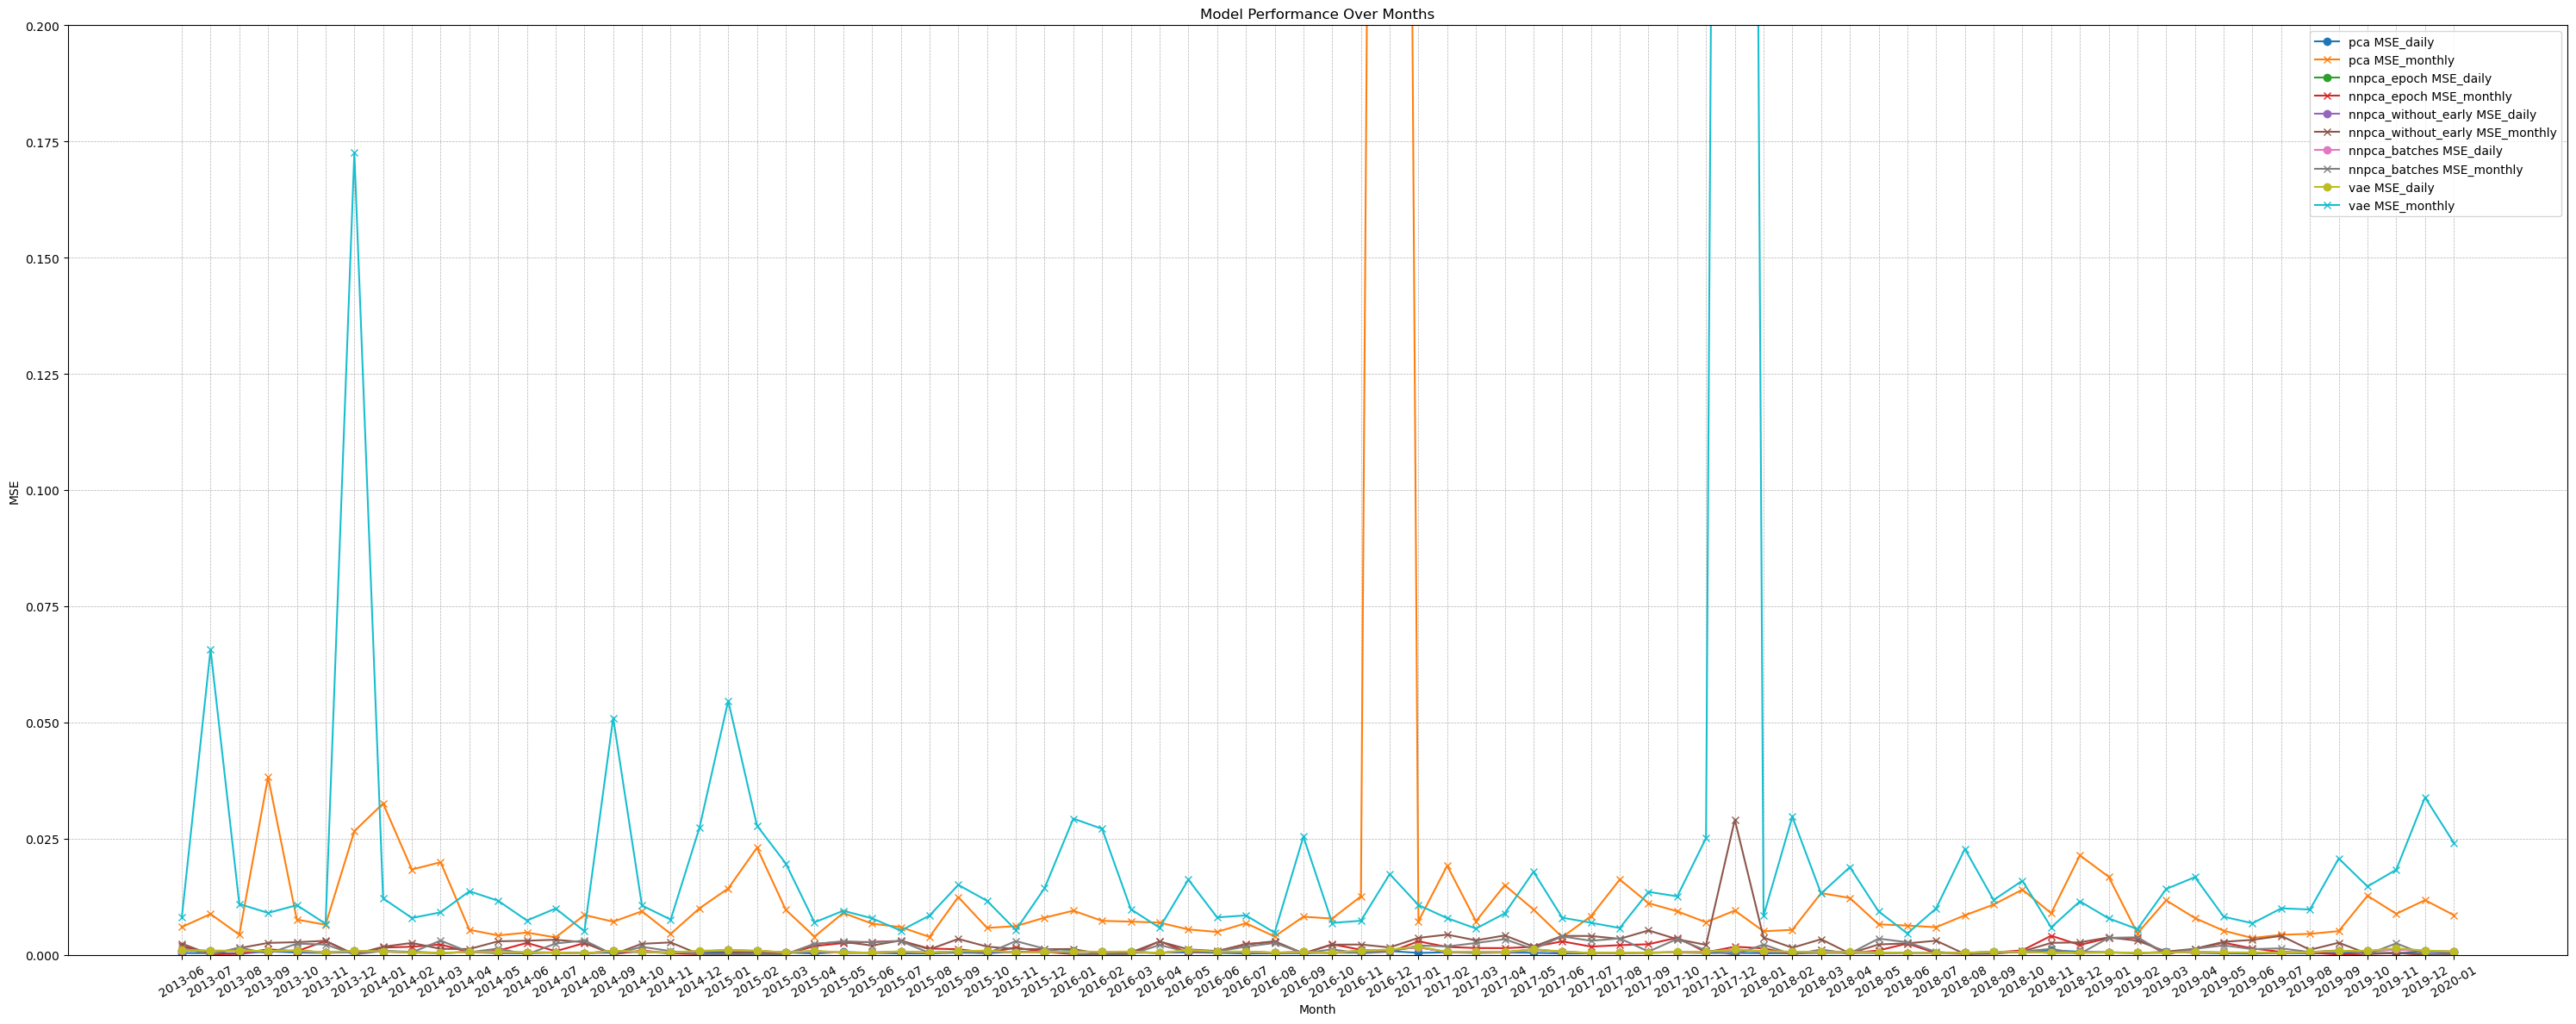

In [51]:
# plot 
import matplotlib.pyplot as plt

months = sorted(list(set(X.index.to_period("M"))))
months_shown = [str(i) for i in months[12:-1]]


plt.figure(figsize=(30, 12))
for model, metrics in Metrics.items():
    plt.plot(months_shown, metrics['MSE_daily'], label=f"{model} MSE_daily", marker='o')
    plt.plot(months_shown, metrics['MSE_monthly'], label=f"{model} MSE_monthly", marker='x')

plt.title('Model Performance Over Months')
plt.xlabel('Month')
plt.xticks(rotation=30)
plt.ylabel('MSE')
plt.ylim([0,0.2])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
